In [1]:
import sys
sys.path.append("../python/")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as colors
from matplotlib.offsetbox import AnchoredText
%matplotlib inline
from _corner import corner
import pickle
from scipy.stats import gaussian_kde, binned_statistic
from scipy.interpolate import UnivariateSpline
from scipy.optimize import minimize

Plot posterior and ML estimators

0.40842391788918375 1.0483570385720413 5.939668183834853


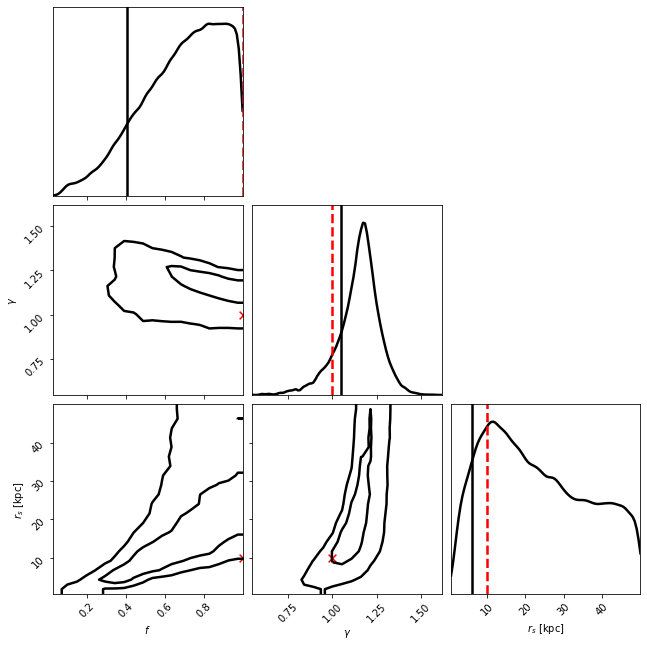

In [2]:
nBDs = 1000; relT = 0.10; relM = 0.10; ex = "ex25"
f_true=1.; rs_true = 10.; gamma_true=1.

_path   = "/hdfs/local/mariacst/exoplanets/results/final_round/"
_file   = open(_path + 
               "likelihood/all_unc/velocity/v200/N%irelT%.2frelM%.2f/like_" %(nBDs, relT, relM) +
               ex + 
               "_N%i_relunc%.2f_relM%.2f_f%.1fgamma%.1frs%.1fv50" %(nBDs, relT, relM, f_true, gamma_true, rs_true),
               "rb") 
like    = pickle.load(_file)
_file   = open(_path + 
               "all_unc/velocity/v200/N%irelT%.2frelM%.2f/posterior_" %(nBDs, relT, relM) +
               ex + 
               "_N%i_relunc%.2f_relM%.2f_f%.1fgamma%.1frs%.1fv50" %(nBDs, relT, relM, f_true, gamma_true, rs_true),
               "rb") 
samples = pickle.load(_file)

smooth=0.5
fig, axes = corner(samples, levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth)

# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], samples.T):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5) 

ML = samples[np.argmax(like)]
axes[0, 0].axvline(ML[0], ls="-", lw=2.5, color="k"); axes[0, 0].axvline(f_true, color="r", ls="--", lw=2.5)
axes[1, 1].axvline(ML[1], ls="-", lw=2.5, color="k"); axes[1, 1].axvline(gamma_true, color="r", ls="--", lw=2.5)
axes[2, 2].axvline(ML[2], ls="-", lw=2.5, color="k");axes[2, 2].axvline(rs_true, color="r", ls="--", lw=2.5)

axes[1, 0].scatter(f_true, gamma_true, marker="x", color="red", s=60)
axes[2, 0].scatter(f_true, rs_true, marker="x", color="red", s=60)
axes[2, 1].scatter(gamma_true, rs_true, marker="x", color="red", s=60)

axes[1, 0].set_ylabel(r"$\gamma$")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 1].set_xlabel(r"$\gamma$")
axes[2, 2].set_xlabel(r"$r_s$ [kpc]")

print(ML[0], ML[1], ML[2])

In [9]:
def LI(L, samples, bin_n=10, verbose=False):
    """
    For each parameter, construct profile likelihood and return the profile likelihood interval
    (i.e. region where the log Likelihood is within 1 of its maximum value)
    
    """   
    # Create bins in Likelihood vs parameter space, find the max Likelihood 
    # value in each bin and the corresponding parameter values
    x = binned_statistic(samples, -L, 'min', bins=bin_n)[1] 
    y = binned_statistic(samples, -L, 'min', bins=bin_n+1)[0]
    
    # Create Interpolation fanction Likelihood - parameter
    #pdb.set_trace()
    z =  UnivariateSpline(x, y, s=0)
    
    # Find in which points crosses 1sigma horizontal line (where 1 sigma 
    # corresponds to 1/2 -for 1 dof-)
    x_tmin     = np.min(samples)
    epsilon    = 1
    niteration = 0
    logLmin    = np.min(y) + 0.5
    while epsilon > 10**-6 and niteration < 20:
        niteration +=1
        minimum = minimize(lambda x: (z(x)-logLmin)**2, x_tmin,
                           bounds=((np.min(samples), samples[np.argmax(L)]),))
        epsilon = minimum.fun
        x_tmin  = x_tmin*1.1
        _min    = minimum.x
        
    if epsilon < 10**-6:
        LImin = _min[0]
    else:
        LImin = np.min(samples)
        
    x_tmax     = samples[np.argmax(L)]
    epsilon    = 1
    niteration = 0
    while epsilon > 10**-6 and niteration < 25:
        niteration +=1
        maximum = minimize(lambda x: (z(x)-logLmin)**2, x_tmax, 
                           bounds=((samples[np.argmax(L)], np.max(samples)),))
        epsilon  = maximum.fun
        x_tmax  = x_tmax*1.1
        _max    = maximum.x
    
    if epsilon < 10**-6:
        LImax = _max[0]
    else:
        LImax = np.max(samples)

    if verbose==True:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        ax.plot(x, y, color="k", lw=2.5)
        ax.axvline(LImin, color="g"); ax.axvline(LImax, color="g")

    #Return
    return  LImin, LImax

(0.5858713282643522, 49.99819280637635)

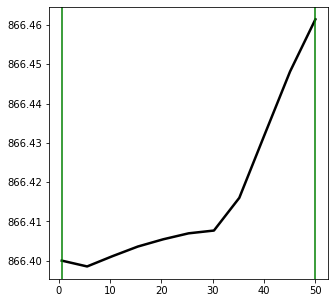

In [13]:
LI_test(like, samples[:, 2], bin_n=10, verbose=True)

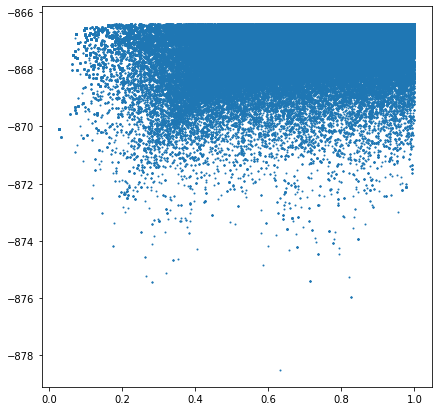

In [11]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000


fig, ax = plt.subplots(1, 1, figsize=(7, 7))
#print(samples[:, 0].shape, like.shape)
ax.scatter(samples[:, 0], like, s=1)

In [8]:
import utils_plots
import imp
imp.reload(utils_plots)
from utils_plots import grid_FSE

../python/utils_plots.py:348: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5', '10', '20'])


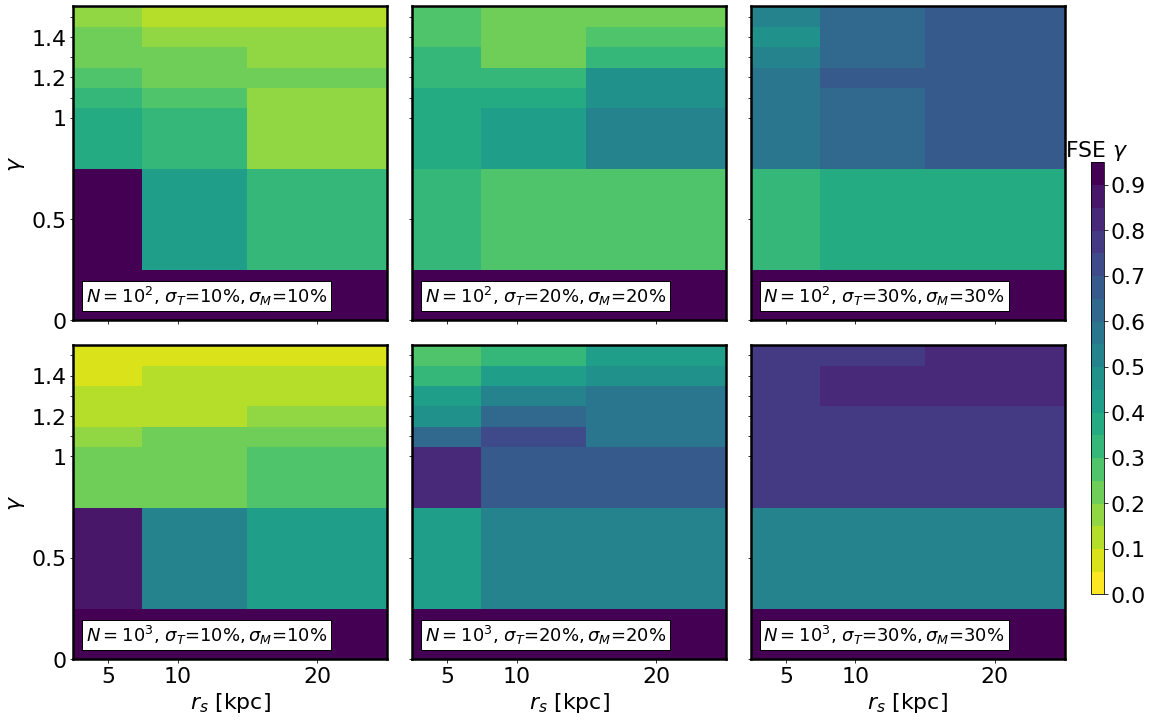

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))

path = "/home/mariacst/exoplanets/results/velocity/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex25", ax[0, 0], "median", False, True, True, False)
im   = grid_FSE(path, 100, 0.2, 0.2, "ex25", ax[0, 1], "median", False, True, False, False)
im   = grid_FSE(path, 100, 0.3, 0.3, "ex25", ax[0, 2], "median", False, True, False, False)

im   = grid_FSE(path, 1000, 0.1, 0.1, "ex25", ax[1, 0], "median", False, True, True, True)
im   = grid_FSE(path, 1000, 0.2, 0.2, "ex25", ax[1, 1], "median", False, True, False, True)
im   = grid_FSE(path, 1000, 0.3, 0.3, "ex25", ax[1, 2], "median", False, True, False, True)

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.91, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title("FSE $\gamma$", size=22.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

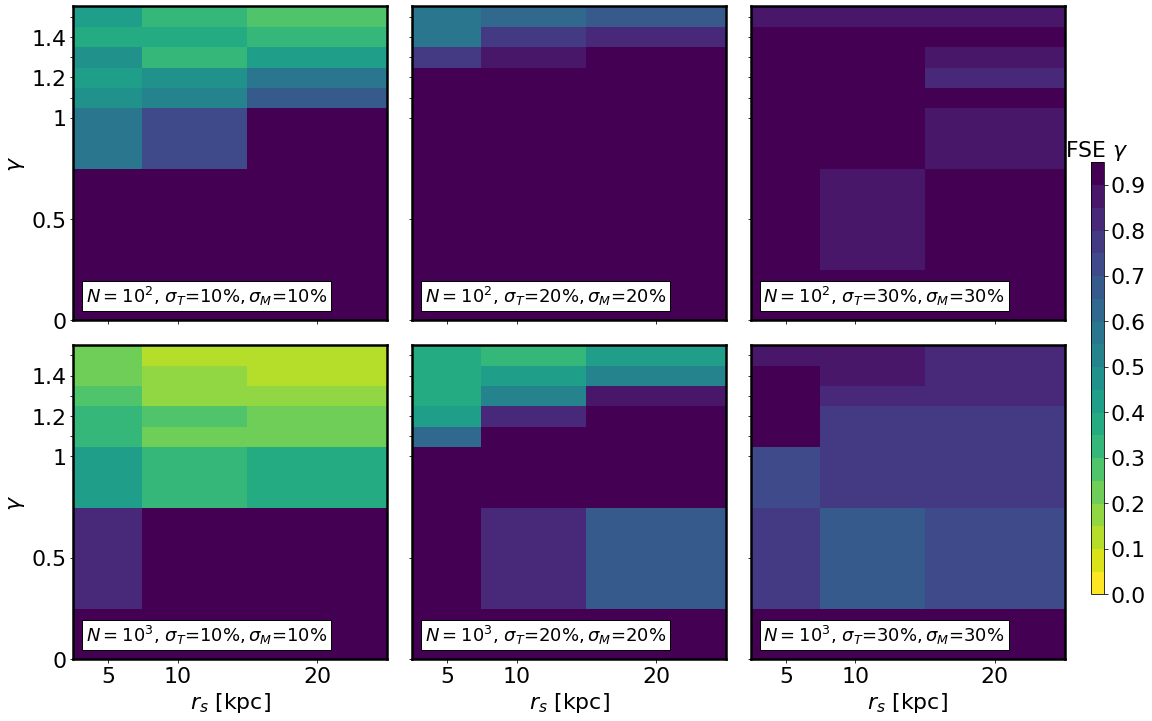

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))

path = "/home/mariacst/exoplanets/results/velocity/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex25", ax[0, 0], "ML", False, True, True, False)
im   = grid_FSE(path, 100, 0.2, 0.2, "ex25", ax[0, 1], "ML", False, True, False, False)
im   = grid_FSE(path, 100, 0.3, 0.3, "ex25", ax[0, 2], "ML", False, True, False, False)

im   = grid_FSE(path, 1000, 0.1, 0.1, "ex25", ax[1, 0], "ML", False, True, True, True)
im   = grid_FSE(path, 1000, 0.2, 0.2, "ex25", ax[1, 1], "ML", False, True, False, True)
im   = grid_FSE(path, 1000, 0.3, 0.3, "ex25", ax[1, 2], "ML", False, True, False, True)

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.91, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title("FSE $\gamma$", size=22.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

In [16]:
def FSE_f_gamma_rs(filepath, nBDs, rel_unc, relM, ex, rank=100, PE="median"):   
    # grid points                                                               
    f     = 1.                                                                      
    rs    = np.array([20.])                                                
    gamma = np.array([1])                         
                                                                                    
    FSE_1 = []; FSE_2 = []; FSE_3 = []                                              
    for _rs in rs:                                                                  
        for _g in gamma:                                                            
            true = [f, _g, _rs]                                                     
            data = np.genfromtxt(filepath + "statistics_" + ex +                    
                                 ("_N%i_relunc%.2f_relM%.2f_f%.1fgamma%.1frs%.1f" 
                                  %(nBDs, rel_unc, relM, f, _g, _rs)), unpack=True)
            if PE=="median":                                                        
                pe = np.array((data[3], data[4], data[5]))                          
            elif PE=="ML":                                                          
                pe = np.array((data[15], data[16], data[17]))                       
            else:                                                                   
                sys.exit("Point estimate not implemented!")                         
            FSE_1.append(np.sqrt(1/rank*np.sum(np.power(pe[0] - true[0], 2)))/true[0])
            if np.abs(_g) < 1e-5:                                                   
                epsilon=1e-4                                                        
            else:                                                                   
                epsilon=0.                                                          
            FSE_2.append(np.sqrt(1/rank*np.sum(np.power(pe[1] - true[1], 2)))/(true[1]+epsilon))
            FSE_3.append(np.sqrt(1/rank*np.sum(np.power(pe[2] - true[2], 2)))/true[2])
                                                                                    
    xi = np.array([2.5, 7.5, 15, 25])                                               
    yi = np.array([0., 0.25, 0.75, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55])             
    xi, yi = np.meshgrid(xi, yi, indexing="ij")                                     
                                                                                    
    zi_1   = np.array(FSE_1).reshape(len(rs), len(gamma))                           
    zi_2   = np.array(FSE_2).reshape(len(rs), len(gamma))                           
    zi_3   = np.array(FSE_3).reshape(len(rs), len(gamma))                           
    # return                                                                        
    return pe, xi, yi, zi_1, zi_2, zi_3

In [31]:
pe, _, _, _, _, _ = FSE_f_gamma_rs(path, 100, 0.1, 0.1, "ex25", rank=100, PE="median")

In [32]:
print (pe.shape, pe[1])

(3, 100) [1.0476 0.942  0.8159 1.2455 1.011  1.1219 1.1283 1.2665 1.3664 0.959
 1.0358 0.8923 1.036  1.1349 0.9497 0.7213 1.0268 1.1965 1.1331 0.9108
 1.2336 1.0369 1.2804 0.9644 0.9902 1.0175 0.6718 1.0662 1.1549 1.2671
 0.8988 0.9748 1.2136 1.0897 1.1343 1.0291 1.0517 1.4166 1.1828 1.0196
 0.9398 0.7995 0.9196 1.1219 1.285  1.0792 0.8853 1.0905 1.018  1.1795
 1.1646 1.0875 1.2354 0.91   1.0746 1.0745 0.9866 0.729  1.0786 0.9108
 0.8468 1.2437 1.1242 1.0392 1.1323 0.9906 0.7748 1.1534 1.0529 1.1469
 1.641  1.0949 1.3548 1.1297 1.1102 1.0804 1.044  1.1837 1.0624 1.0118
 1.0932 1.1077 1.1347 0.8685 1.3373 1.2879 1.1565 1.0628 1.2111 1.1866
 0.7483 1.1276 1.4054 0.7443 1.2084 1.2123 0.9245 1.2064 1.0371 1.1155]


In [33]:
np.sqrt(1/100*np.sum(np.power(pe[1] - 1., 2)))

0.1792928648887066

xvals =  (4.922753073810515e-05, 2.224383319197255)
yvals =  (0.0, 1.0999999999999213)
4.922753073810515e-05 2.224383319197255    -0.42957571067294964 1.0
0.243870576864742 49.99905197279563    0.9165547924228008 1.0
0.0006990402546363517 0.9999905832354677    0.7611694909678874 1.0
0.9861131931492482 0.6619882846653002 9.117964238681903


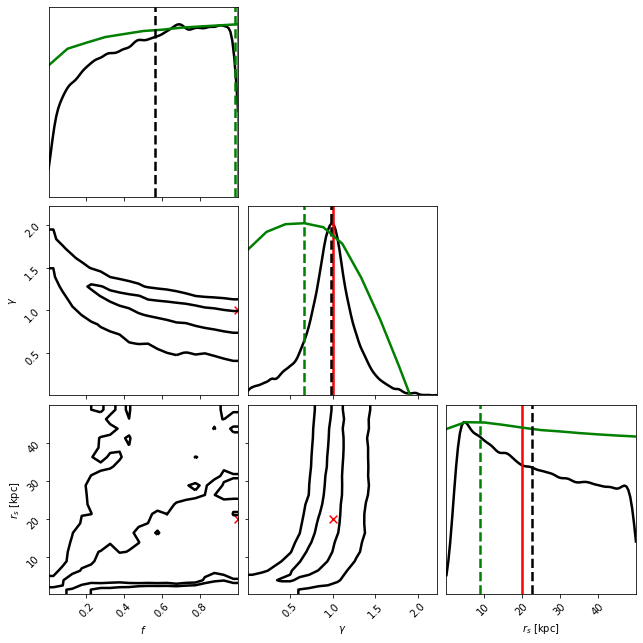

In [6]:
nBDs = 100; relT = 0.10; relM = 0.10; ex = "ex25"
f_true=1.; rs_true = 20.; gamma_true=1.

_path   = "/hdfs/local/mariacst/exoplanets/results/final_round/"
_file   = open(_path + 
               "likelihood/all_unc/velocity/v200/N%irelT%.2frelM%.2f/like_" %(nBDs, relT, relM) +
               ex + 
               "_N%i_relunc%.2f_relM%.2f_f%.1fgamma%.1frs%.1fv32" %(nBDs, relT, relM, f_true, gamma_true, rs_true),
               "rb") 
like    = pickle.load(_file)
_file   = open(_path + 
               "all_unc/velocity/v200/N%irelT%.2frelM%.2f/posterior_" %(nBDs, relT, relM) +
               ex + 
               "_N%i_relunc%.2f_relM%.2f_f%.1fgamma%.1frs%.1fv32" %(nBDs, relT, relM, f_true, gamma_true, rs_true),
               "rb") 
samples = pickle.load(_file)

smooth=0.5
fig, axes = corner(samples, levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth)

# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], samples.T):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5) 
    if axidx==4:
        #print(xvals, kde(xvals)/np.max(kde(xvals)))
        xvals = fig.axes[axidx].get_xlim()
        yvals = fig.axes[axidx].get_ylim()
        print("xvals = ", xvals)
        print("yvals = ", yvals)

ML = samples[np.argmax(like)]
axes[0, 0].axvline(ML[0], ls="--", lw=2.5, color="g"); axes[0, 0].axvline(f_true, color="r", ls="-", lw=2.5)
axes[1, 1].axvline(ML[1], ls="--", lw=2.5, color="g"); axes[1, 1].axvline(gamma_true, color="r", ls="-", lw=2.5)
axes[2, 2].axvline(ML[2], ls="--", lw=2.5, color="g"); axes[2, 2].axvline(rs_true, color="r", ls="-", lw=2.5)

axes[1, 1].axvline(0.9748, color="k", ls="--", lw=2.5)
bin_n=10
x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
#print(y)
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[1, 1].plot(x, y, ls="-", color="green", lw=2.5)

x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]
#print(y)
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[2, 2].plot(x, y, ls="-", color="green", lw=2.5)
axes[2, 2].axvline(22.6111, color="k", ls="--", lw=2.5)

x = binned_statistic(samples[:, 0], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 0], like, 'max', bins=bin_n+1)[0]
#print(y)
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[0, 0].plot(x, y, ls="-", color="green", lw=2.5)
axes[0, 0].axvline(0.5637, color="k", ls="--", lw=2.5)

axes[1, 0].scatter(f_true, gamma_true, marker="x", color="red", s=60)
axes[2, 0].scatter(f_true, rs_true, marker="x", color="red", s=60)
axes[2, 1].scatter(gamma_true, rs_true, marker="x", color="red", s=60)

axes[1, 0].set_ylabel(r"$\gamma$")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 1].set_xlabel(r"$\gamma$")
axes[2, 2].set_xlabel(r"$r_s$ [kpc]")

print(ML[0], ML[1], ML[2])

In [63]:
print (pe[:, 31])

[ 0.5637  0.9748 22.6111]


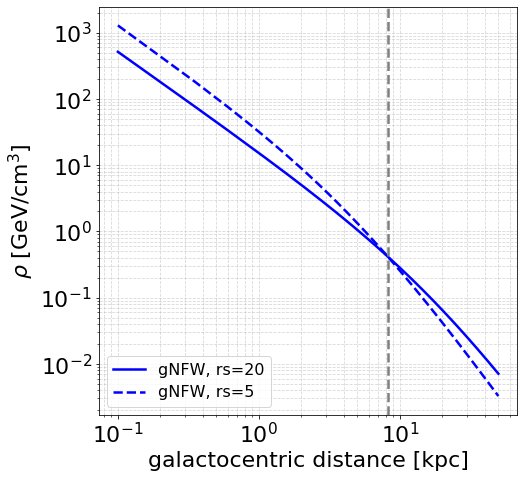

In [68]:
from utils import gNFW_rho

r  = np.linspace(0.1, 50, 200)
R0 = 8.178

rho1 = gNFW_rho(R0, r, [1.5, 20., 0.42])
rho2 = gNFW_rho(R0, r, [1.5, 5., 0.42])

fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5))
ax.plot(r, rho1, color="blue", lw=2.5, label="gNFW, rs=20")
ax.plot(r, rho2, color="blue", lw=2.5, ls="--", label=r"gNFW, rs=5")

ax.axvline(R0, ls="--", color="grey", lw=2.5)

ax.grid(which="both", ls="--", alpha=0.5)
ax.set_ylabel(r"$\rho$ $\rm [GeV/cm^3]$")
ax.set_xlabel("galactocentric distance [kpc]")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(fontsize=16)

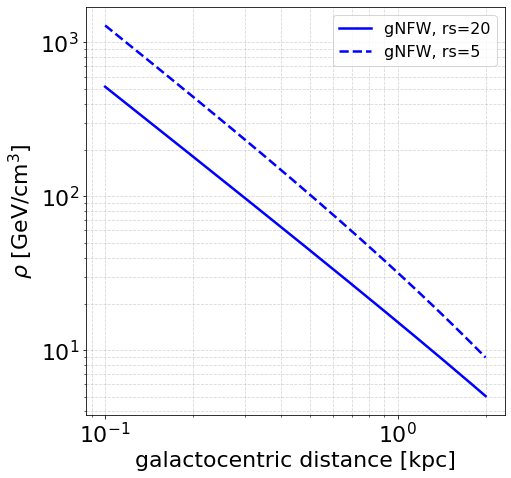

In [69]:
from utils import gNFW_rho

r  = np.linspace(0.1, 2, 200)
R0 = 8.178

rho1 = gNFW_rho(R0, r, [1.5, 20., 0.42])
rho2 = gNFW_rho(R0, r, [1.5, 5., 0.42])

fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5))
ax.plot(r, rho1, color="blue", lw=2.5, label="gNFW, rs=20")
ax.plot(r, rho2, color="blue", lw=2.5, ls="--", label=r"gNFW, rs=5")

#ax.axvline(R0, ls="--", color="grey", lw=2.5)

ax.grid(which="both", ls="--", alpha=0.5)
ax.set_ylabel(r"$\rho$ $\rm [GeV/cm^3]$")
ax.set_xlabel("galactocentric distance [kpc]")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(fontsize=16)

In [16]:
def FSE_f(filepath, nBDs, rel_unc, relM, ex, _g, _rs, rank=100, PE="median"):   
    # grid points                                                               
    f     = 1.                                                                      
    rs    = np.array([20.])                                                
    gamma = np.array([1])                         
                                                                                    
    FSE_1 = []; FSE_2 = []; FSE_3 = []                                              
   
            
    true = [f, _g, _rs]                                                     
    data = np.genfromtxt(filepath + "statistics_" + ex +                    
                         ("_N%i_relunc%.2f_relM%.2f_f%.1fgamma%.1frs%.1f" 
                          %(nBDs, rel_unc, relM, f, _g, _rs)), unpack=True)
    if PE=="median":                                                        
        pe = np.array((data[3], data[4], data[5]))                          
    elif PE=="ML":                                                          
        pe = np.array((data[15], data[16], data[17]))                       
    else:                                                                   
        sys.exit("Point estimate not implemented!")                         
    FSE_1.append((pe[0] - true[0])/true[0])
    if np.abs(_g) < 1e-5:                                                   
        epsilon=1e-4                                                        
    else:                                                                   
        epsilon=0.                                                          
    FSE_2.append((pe[1] - true[1])/(true[1]+epsilon))
    FSE_3.append((pe[2] - true[2])/true[2])
                                                                                                             
    # return                                                                        
    return FSE_1, FSE_2, FSE_3

Text(0.5, 0, '$\\frac{\\gamma^{true}-\\gamma^{reconst.}}{\\gamma^{true}}$')

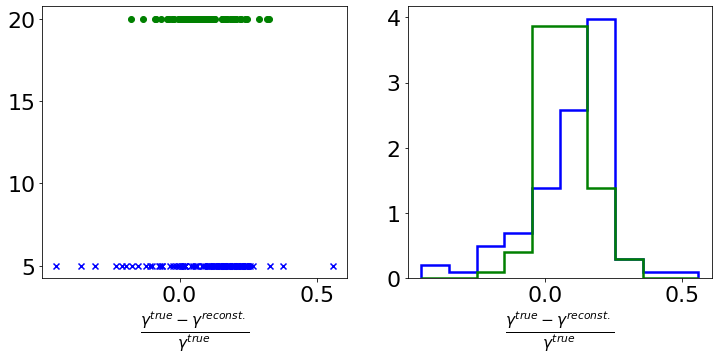

In [30]:
_, FSE_2_5, _  = FSE_f(path, 100, 0.1, 0.1, "ex25", 1.5, 5., rank=100, PE="median")
_, FSE_2_20, _ = FSE_f(path, 100, 0.1, 0.1, "ex25", 1.5, 20., rank=100, PE="median")


fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(FSE_2_5, np.ones(np.shape(FSE_2_5))*5., marker="x", color="blue")
ax[0].scatter(FSE_2_20, np.ones(np.shape(FSE_2_20))*20, marker="o", color="green")

_, bins, _= ax[1].hist(FSE_2_5, color="blue", linewidth=2.5, histtype="step", density=True) 
# tendría que normalizarlo con respecto a 1!!!!
ax[1].hist(FSE_2_20, color="green", linewidth=2.5, histtype="step", bins=bins, density=True)

ax[0].set_xlabel(r"$\frac{\gamma^{true}-\gamma^{reconst.}}{\gamma^{true}}$")
ax[1].set_xlabel(r"$\frac{\gamma^{true}-\gamma^{reconst.}}{\gamma^{true}}$")

## Following some of the steps indicated by Trotta 

In [3]:
from mock_generation import mock_population
from utils import temperature_withDM, heat
from scipy.interpolate import griddata
from astropy.constants import R_jup, M_sun

In [5]:
nBDs = 100; relT=0.1; relM=0.1;
f_true=1.; gamma_true=1.5; rs_true=20.;
rho0=0.42


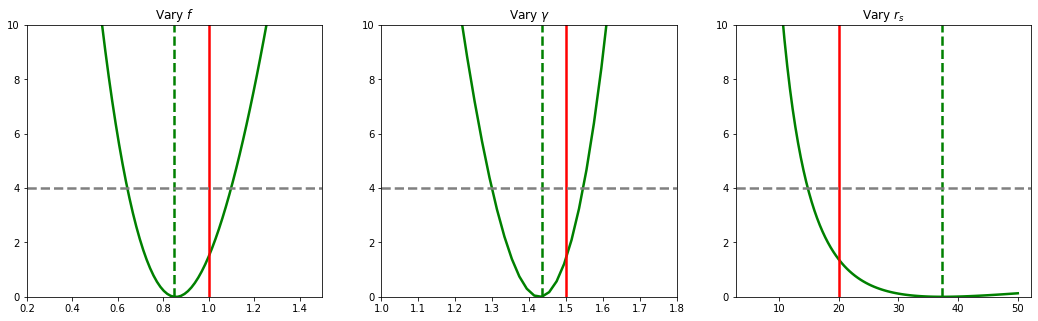

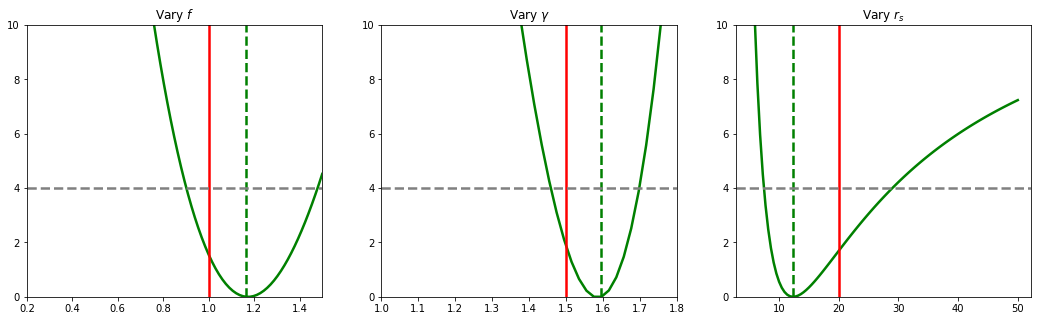

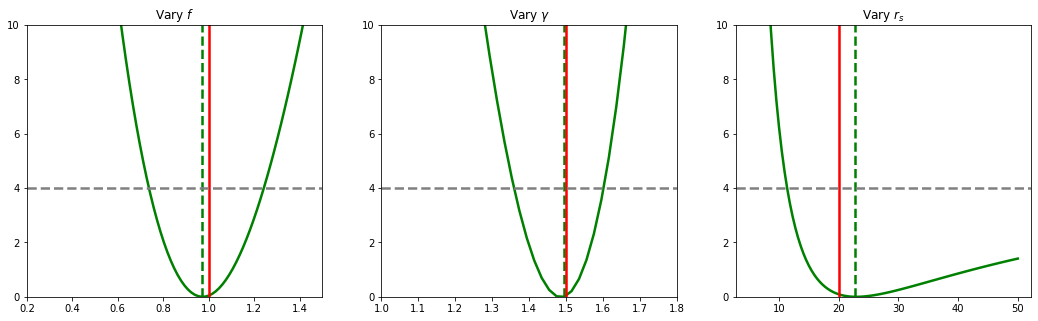

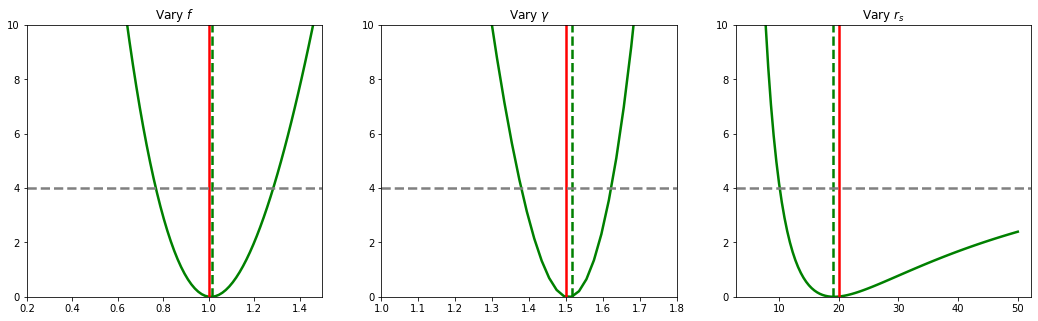

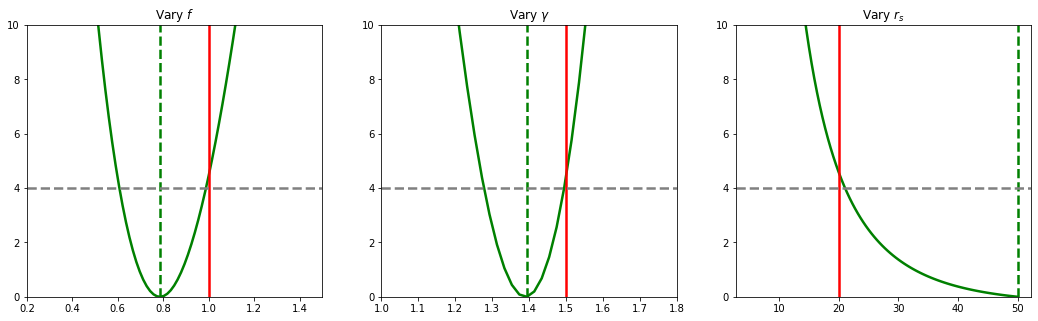

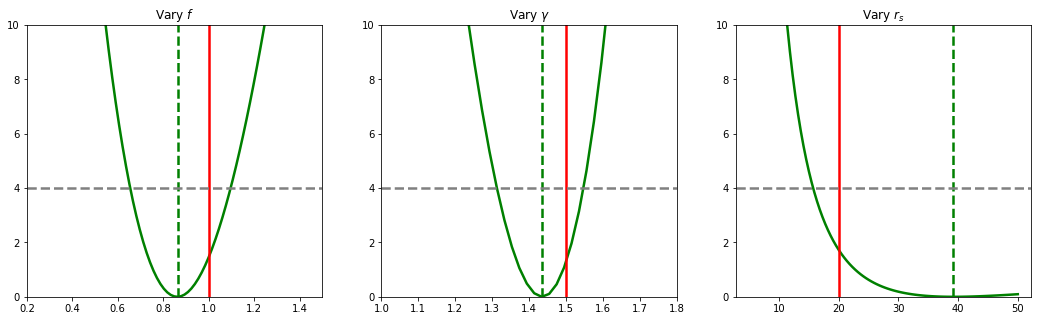

In [31]:
def residual(p, robs, Tobs, rel_unc_Tobs, heat_int, mass):                   
    f, gamma, rs = p                                                            
    Tmodel = temperature_withDM(robs, heat_int, f=f, M=mass*M_sun.value,        
                                parameters=[gamma, rs, rho0])                   
    return -0.5*np.sum(((Tmodel-Tobs)/(rel_unc_Tobs*Tobs))**2.) 


for k in range(6):
    
    #np.random.seed(21)
    robs, Tobs, mass, ages = mock_population(nBDs, relT, relM, f_true, gamma_true, rs_true, rho0_true=rho0) 
    
    # Load theoretical cooling model
    path = "./data/"                                                                
    data = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)            
    points = np.transpose(data[0:2, :])                                             
    values = data[2]  
    # calculate predictic intrinsic heat flow for mock BDs                         
    xi = np.transpose(np.asarray([ages, mass]))                                     
    Teff     = griddata(points, values, xi)                                         
    heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)
    
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    
    Npoints = 100
    
    ax[0].set_title("Vary $f$")
    f      = np.linspace(0, 1.5, Npoints)
    like_f = np.zeros(Npoints)
    for i in range(Npoints):
        like_f[i] = residual([f[i], gamma_true, rs_true], robs, Tobs, relT, heat_int, mass)
    ax[0].plot(f, -like_f+np.max(like_f), color="green", lw=2.5); ax[0].axvline(f[np.argmax(like_f)], color="green", lw=2.5, ls="--")
    ax[0].axvline(f_true, color="red", lw=2.5); ax[0].set_ylim(0, 10); ax[0].set_xlim(0.2, 1.5)
    ax[0].axhline(4, color="grey", ls="--", lw=2.5)
    
    
    ax[1].set_title("Vary $\gamma$")
    gamma      = np.linspace(0, 2., Npoints)
    like_gamma = np.zeros(Npoints)
    for i in range(Npoints):
        like_gamma[i] = residual([f_true, gamma[i], rs_true], robs, Tobs, relT, heat_int, mass)
    ax[1].plot(gamma, -like_gamma+np.max(like_gamma), color="green", lw=2.5); 
    ax[1].axvline(gamma[np.argmax(like_gamma)], color="green", lw=2.5, ls="--"); 
    ax[1].axvline(gamma_true, color="red", lw=2.5); ax[1].set_ylim(0, 10); ax[1].set_xlim(1., 1.8)
    ax[1].axhline(4, color="grey", ls="--", lw=2.5)
    
    ax[2].set_title("Vary $r_s$")
    rs      = np.linspace(5., 50., Npoints)
    like_rs = np.zeros(Npoints)
    for i in range(Npoints):
        like_rs[i] = residual([f_true, gamma_true, rs[i]], robs, Tobs, relT, heat_int, mass)
    ax[2].plot(rs, -like_rs+np.max(like_rs), color="green", lw=2.5); 
    ax[2].axvline(rs[np.argmax(like_rs)], color="green", lw=2.5, ls="--"); 
    ax[2].axvline(rs_true, color="red", lw=2.5); ax[2].set_ylim(0, 10)
    ax[2].axhline(4, color="grey", ls="--", lw=2.5)